In [1]:
import pandas as pd
import requests

In [2]:
token_inegi = "eef38b38-7281-b857-9747-2d539badae17"

id_mercancias = 628224
id_servicios = 628225
id_agropecuarios = 628227
id_energeticos = 628228

token_banxico = "d3a0d52eac0e8a441b2aed2db831df7a0057b2d65b815a6366261949ca8c12ac"
tipo_de_cambio = "SF63528"

In [3]:
def get_data_banxico(
    token_banxico,
    fecha_inicial="2018-01-01",
    fecha_final="2020-10-19"):
    
    url = "https://www.banxico.org.mx/SieAPIRest/service/v1/series/"+tipo_de_cambio+"/datos/"+fecha_inicial+"/"+fecha_final+"?token="+token_banxico
    result = requests.get(url).json()

    dict_data = result['bmx']['series'][0]['datos']
    data = [(dict_data[i]['fecha'], dict_data[i]['dato']) for i in range(len(dict_data))]

    return pd.DataFrame(data, columns=['fecha', "tipo_cambio"])

In [39]:
def get_data_inegi(token_inegi, variable):
    url = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/"+str(variable)+"/es/00/false/BIE/2.0/"+token_inegi+"?type=json"
    result = requests.get(url).json()
    
    url = "https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/CL_INDICATOR/"+str(variable)+"/es/BIE/2.0/"+token_inegi+"?type=json"
    var_name = requests.get(url).json()['CODE'][0]['Description']

    dict_data = result['Series'][0]['OBSERVATIONS']
    data = [(dict_data[i]['TIME_PERIOD'], dict_data[i]['OBS_VALUE']) for i in range(len(dict_data))]
    result = pd.DataFrame(data, columns=['fecha', var_name])
    result[var_name] = result[var_name].astype(float)
    return result

In [79]:
def tc_quincenal(
    tc):
    
    tc.fecha = pd.to_datetime(tc.fecha)
    tc.tipo_cambio = tc.tipo_cambio.astype(float)
    tc_quincenal = tc.groupby([pd.Grouper(key='fecha', freq='SM', label='right')])['tipo_cambio'].mean().reset_index().sort_values('fecha')
    
    tc_quincenal.index = tc_quincenal.fecha
    years = tc_quincenal.index.year.to_numpy().tolist()
    mes = tc_quincenal.index.month.to_numpy().tolist()
    quincena = [1,2]*len(tc_quincenal)
    
    var_quinena = [str(years[i])+"_"+str(mes[i])+"_"+str(quincena[i]) for i in range(len(tc_quincenal))]
    tc_quincenal['quincena'] = var_quinena
    
    return tc_quincenal

In [81]:
def inegi_quincenal(
    datos):
    
    datos.fecha = pd.to_datetime(datos.fecha)
    datos.index = datos.fecha
    years = datos.index.year.to_numpy().tolist()
    mes = datos.index.month.to_numpy().tolist()
    quincena = [1,2]*len(datos)

    var_quinena = [str(years[i])+"_"+str(mes[i])+"_"+str(quincena[i]) for i in range(len(datos))]
    datos['quincena'] = var_quinena
    
    return datos

### Banxico calls

In [ ]:
tc = get_data_banxico(
    token_banxico,
    fecha_inicial="2010-01-01",
    fecha_final="2020-10-28")

tc_datos_quincenal = tc_quincenal(tc)

#### INEGI calls

In [83]:
merc = inegi_quincenal(get_data_inegi(token_inegi, id_mercancias))
servicios = inegi_quincenal(get_data_inegi(token_inegi, id_servicios))
agropecuarios = inegi_quincenal(get_data_inegi(token_inegi, id_agropecuarios))
energeticos = inegi_quincenal(get_data_inegi(token_inegi, id_energeticos))

In [84]:
result = (tc_datos_quincenal.merge(merc, how='inner', on='quincena')
          .merge(servicios.drop('fecha', axis=1), how='inner', on='quincena')
          .merge(agropecuarios.drop('fecha', axis=1), how='inner', on='quincena')
          .merge(energeticos.drop('fecha', axis=1), how='inner', on='quincena')
         )

In [85]:
result.columns = ['fecha_x','tipo_cambio','quincena','fecha_y','mercancias','servicios','agropecuarios','energ_tarifas']
result.index = result.fecha_x
result = result.drop(['fecha_x','fecha_y','quincena'], axis=1)

In [86]:
result

,tipo_cambio,mercancias,servicios,agropecuarios,energ_tarifas
fecha_x,,,,,
2010-01-15,12.725789,72.219077,79.153931,63.085185,62.083203
2010-01-31,12.831645,72.416435,79.453035,64.046489,62.327869
2010-02-15,12.785671,72.579521,79.542866,63.657698,62.810027
2010-02-28,12.850750,72.676743,79.696681,64.615063,63.147200
2010-03-15,12.609450,72.761275,79.870310,66.457549,63.414325
...,...,...,...,...,...
2020-08-15,22.068960,109.594726,106.350182,112.754948,102.836163
2020-08-31,22.032890,109.870051,106.459850,112.866631,102.976322
2020-09-15,21.257175,110.047007,106.640404,113.055655,103.124218


In [140]:
from_date = '2010-01-15'

for c in result.columns:
    result[c+'_index'] = result[c] / result.loc[from_date,c]*100

result_plot = result.loc[result.index >= from_date]

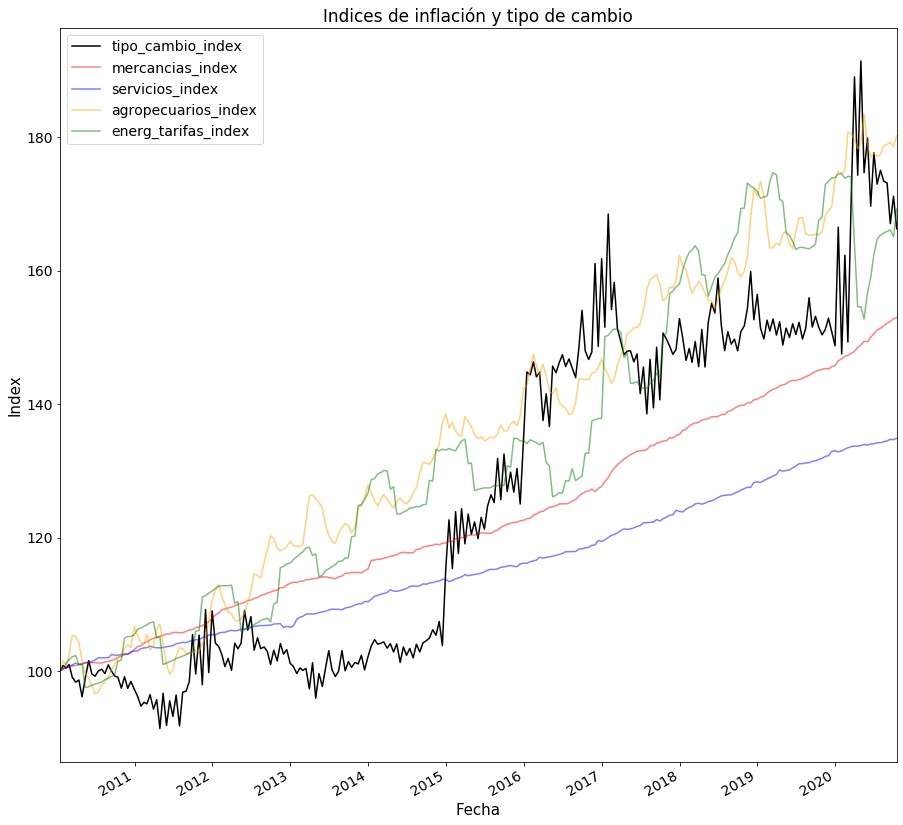

In [141]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"]=15,15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax = plt.gca()

result_plot.plot(kind='line',y='tipo_cambio_index',color='black', ax=ax)
result_plot.plot(kind='line',y='mercancias_index', color='red', ax=ax, alpha=0.5)
result_plot.plot(kind='line',y='servicios_index', color='blue', ax=ax, alpha=0.5)
result_plot.plot(kind='line',y='agropecuarios_index', color='orange', ax=ax, alpha=0.5)
result_plot.plot(kind='line',y='energ_tarifas_index', color='green', ax=ax, alpha=0.5)

plt.xlabel('Fecha', fontsize=15)
plt.ylabel('Index', fontsize=15)
plt.title("Indices de inflación y tipo de cambio", size=17)
plt.show()

In [139]:
print("Correlaciones Spearman")
result_plot[['mercancias','servicios','agropecuarios','energ_tarifas']].corrwith(result_plot.tipo_cambio, method='spearman')

Correlaciones Spearman


mercancias       0.628701
servicios        0.627823
agropecuarios    0.572951
energ_tarifas   -0.088116
dtype: float64